# Реальная заработная плата в России
Федеральная служба государственной статистики ежемесячно оценивает среднюю реальную заработную плату в России; известны значения с января 1993 по январь 2017 (источник: [http://sophist.hse.ru/exes/tables/WAG_M.htm]. Необходимо построить прогноз на следующие три года.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import pylab
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing, HoltWintersResults
pylab.rcParams['figure.figsize'] = (10, 8)

RANDOM_SEED = 41238
np.random.seed(RANDOM_SEED)

In [86]:
data = pd.read_csv('monthly-wage.csv', sep=';', index_col="Month", parse_dates=["Month"])

In [87]:
test = data.loc['2014-02':].copy()
data = data.loc[:'2014-01'].copy()

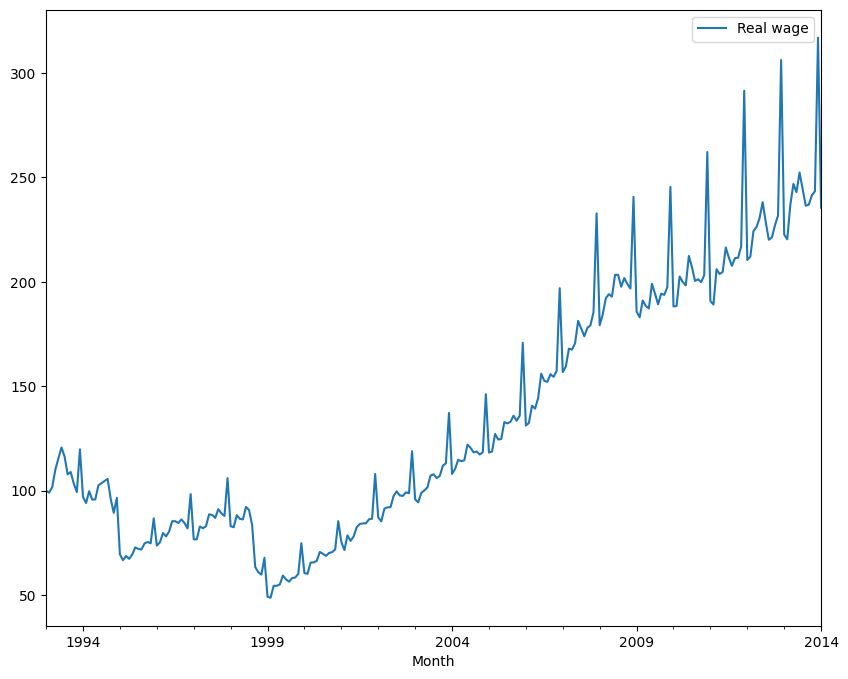

In [88]:
data.plot()
plt.show()

Заметим, что в первые 5 лет признак ведёт себя и меняется не так, как в следующие годы; чтобы модель не перенастраивалась на неактуальные данные, будем рассматривать значения ряда только с января 1999.

In [89]:
data = data.loc['1999-01'::].copy()

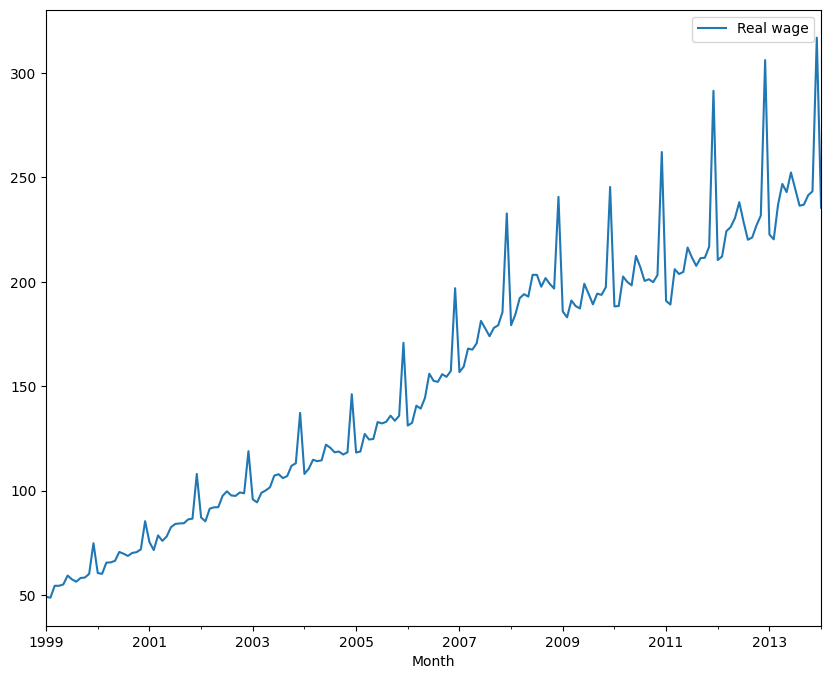

In [90]:
data.plot()
plt.show()

1. Попробуйте поделить на число дней в месяце. Стал ли ряд более регулярным? В противном случае вернитесь к исходным данным.

In [91]:
if data.index.name == 'Month':
    data.reset_index(inplace=True)
data.rename(columns={'Month': 'month', 'Real wage': 'real_wage'}, inplace=True)

In [92]:
data['days_in_month'] = data['month'].dt.days_in_month

In [93]:
data['real_wage_normalized'] = data['real_wage'] / data['days_in_month']

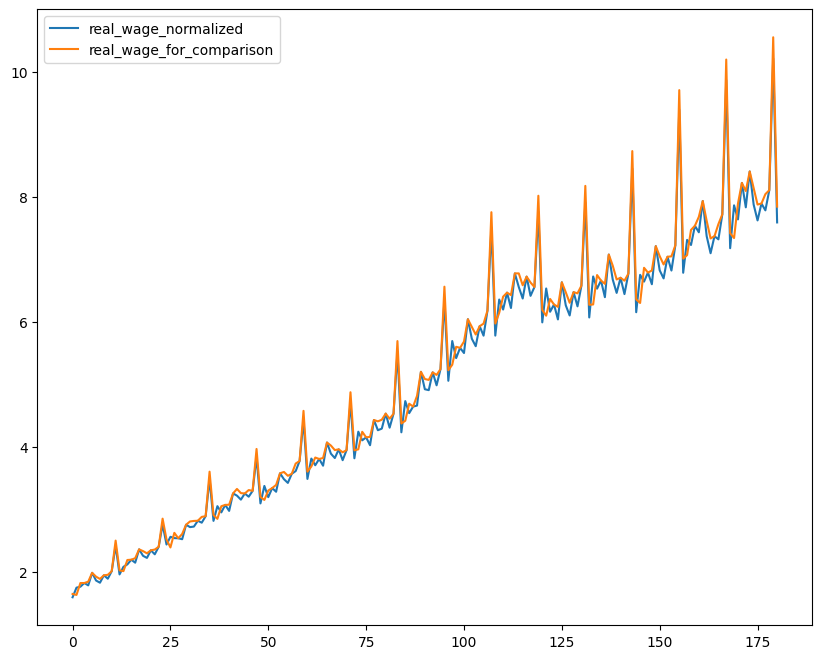

In [97]:
data['real_wage_for_comparison'] = data['real_wage'] / 30

data[['real_wage_normalized', 'real_wage_for_comparison']].plot()
plt.show()

Будем использовать `real_wage_normalized`

In [99]:
data.drop(columns=['real_wage_for_comparison'], inplace=True)

2. Сделайте STL-декомпозицию ряда. Для этого воспользуйтесь функцией `seasonal_decompose` из `statsmodels`.

In [133]:
stl_decomposition = seasonal_decompose(data.set_index('month')['real_wage_normalized'])

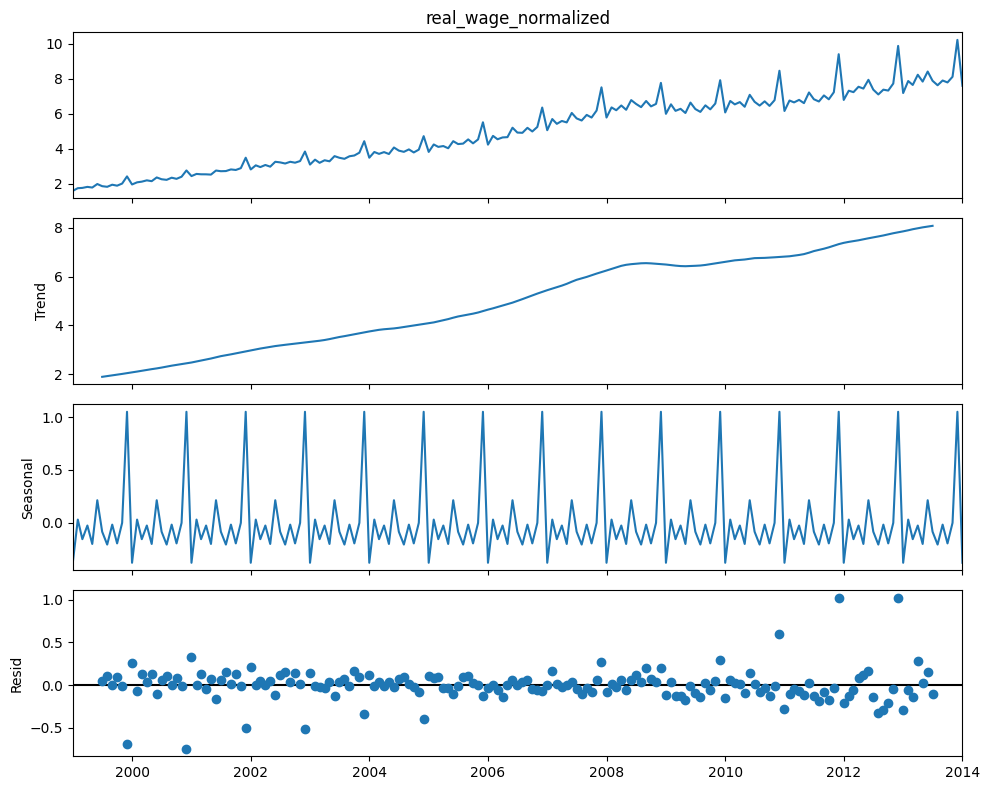

In [134]:
stl_decomposition.plot()
plt.show()

3. Проведите преобразование Бокса-Кокса, имеет ли смысл его использовать?

In [140]:
boxcox, maxlog = scipy.stats.boxcox(data['real_wage_normalized'])
print(maxlog)

0.6429689658188341


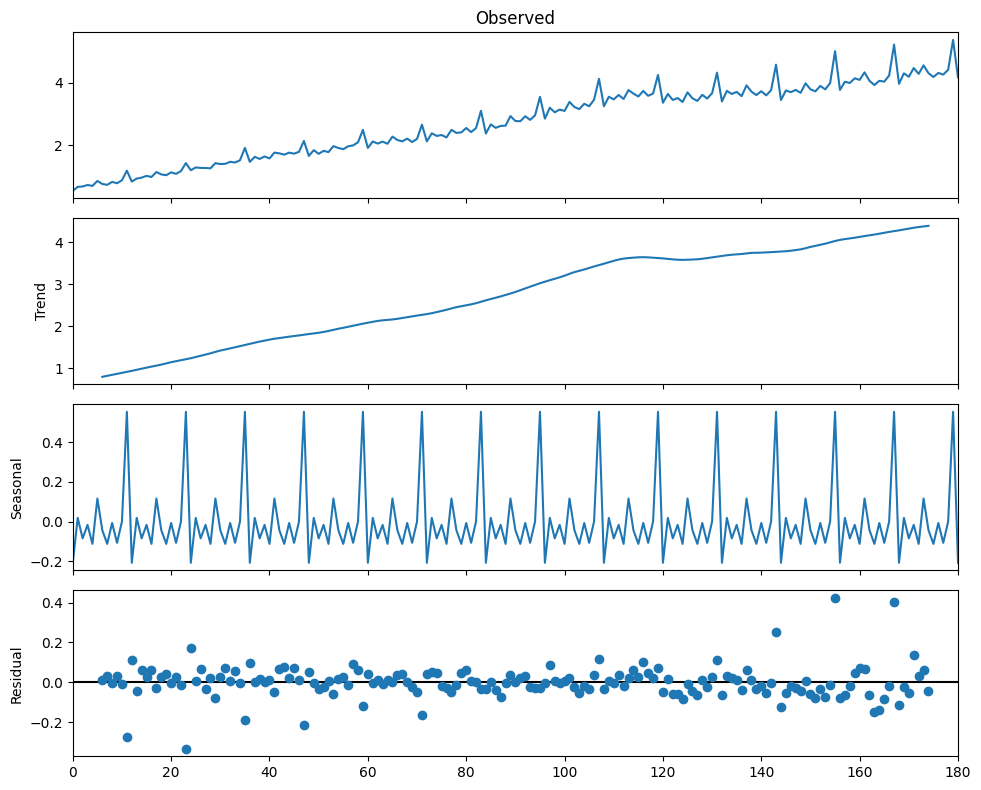

In [142]:
stl_decomposition = seasonal_decompose(boxcox, period=12)
stl_decomposition.plot()
plt.show()

**Ответ**: Не похоже, что преобразование Бокса-Кокса как-то помогает. Может оно бы помогало, если бы ряд

## Прогноз ARIMA

4. Воспользуйтесь функцией `auto_arima` из `pmdarima` для автоматического подбора параметров модели (stepwise=True).

5. Проведите анализ остатков модели.   

    - Нарисуйте их график;
    - Рассмотрите графики ACF и PACF (`plot_acf` и `plot_pacf` из `statsmodels`);
    - Проиллюстрируйте достигаемые уровни значимости критерия Льюнга-Бокса для них (`acorr_ljungbox` из `statsmodels`);
    - Постройте Q-Q plot;
    - Рассмотрите график распределения остатков (постройте гистограмму)

6. Проверьте остатки на
    - нормальность
    - несмещенность
    - стационарность (`kpss` из `statsmodels`)

In [11]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', '?', None],
                                 ['Несмещённость', 'Уилкоксона', '?', None],
                                 ['Стационарность', 'KPSS', '?', None]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 
                            'Достигаемый уровень значимости']
table_hypothesis

,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,?,None
1,Несмещённость,Уилкоксона,?,None
2,Стационарность,KPSS,?,None


### Ручной подбор модели

7. Найдите порядок интегрированности ряда и рассмотрите графики ACF и PACF. Основываясь на полученных результатах сделайте предположение о настройках ARIMA-модели. 

8. Исходя из пункта 7 в `auto_arima(stepwise=False)` настройте параметры `start_p, start_q, max_p, max_q, max_P, max_Q, m, max_order, d, D, seasonal`. Сравните две полученные модели ARIMA.

9. Постройте прогноз с помощью ARIMA и выведите его на графике вместе с реальными значениями.

## Прогноз ETS

10. Постройте прогноз с помощью моделей экспоненциального сглаживания. Для этого можете воспользоваться руководством https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

11. Проведите анализ остатков моделей. Как и в предыдущий раз:

    - Нарисуйте их график;
    - Рассмотрите графики ACF и PACF;
    - Проиллюстрируйте достигаемые уровни значимости критерия Льюнга-Бокса для них;
    - Постройте Q-Q plot;
    - Рассмотрите график распределения остатков (постройте гистограмму).

12. Проверьте остатки на
    - нормальность
    - несмещенность
    - стационарность (`kpss` из `statsmodels`)

In [12]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', '?', None],
                                 ['Несмещённость', 'Уилкоксона', '?', None],
                                 ['Стационарность', 'KPSS', '?', None]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 
                            'Достигаемый уровень значимости']
table_hypothesis

,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,?,None
1,Несмещённость,Уилкоксона,?,None
2,Стационарность,KPSS,?,None


## Итог

13. Сравните прогнозы лучшей ETS модели и модели ARIMA с помозью известных вам метрик качества прогноза.